In [1]:
import os
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import itertools
from functools import reduce

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())
from plotnine import *
from mizani.palettes import brewer_pal
from palettable import colorbrewer
palette=brewer_pal(type='qual', palette='Set1')

from mcmcmd.samplers import *
from mcmcmd.tests import *

import igraph
import joblib
import grakel

import scipy

/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.


# Helper functions

In [2]:
def b_nk(n, k, A, B, B_terms):
    if (n, k) not in B:
        if n == k:
            B_terms[(n, k)] = onp.array([1])
            B[(n, k)] = 1
        else:
            s = onp.arange(1, n-k+1)
            B_terms[(n, k)] = ((2**k-1)**s * 2**(k*(n-k-s)) * A[n-k-1, :][s-1]).astype('int')
            B[(n, k)] = int(B_terms[(n, k)].sum())
    return B[(n, k)]

def count_DAG(num_nodes):
    A = onp.identity(num_nodes, dtype='int')
    B = {}
    B_terms = {}

    for n in range(1, num_nodes+1):
        for k in range(1, n+1):
            A[n-1, k-1] = scipy.special.comb(n, k, exact=True) * b_nk(n, k, A, B, B_terms)
    
    # A[n-1, k-1] is the number of DAGs with n nodes and k outpoints (roots).
    return A

# Sample a DAG uniformly using the enumeration method from Kuipers and Moffa 2013.
def sample_uniform_DAG(num_nodes, rng=None):
    assert num_nodes > 0 and num_nodes <= 10 # overflow
    if rng is None:
        rng = onp.random.default_rng()

    A = count_DAG(num_nodes)
    
    K = [] # List of k
    n = num_nodes
    
    r = rng.choice(A[n-1, :].sum())+1
    
    k = 1
    while r > A[n-1, k-1]:
        r -= A[n-1, k-1]
        k += 1
    K.append(k)

    r = int(onp.ceil(r/scipy.special.comb(n, k, exact=True)))
    m = n-k
    while m > 0:
        s = 1
        t = int((2**k - 1)**s * 2**(k*(m-s)) * A[m-1, s-1])
        while r > t:
            r -= t
            s += 1
            t = (2**k - 1)**s * 2**(k*(m-s)) * A[m-1, s-1]
        
        r = int(onp.ceil(r/(scipy.special.comb(m, s, exact=True) * t/A[m-1, s-1])))
        
        n = m
        k = s
        m = n-k
        K.append(k)

    Q = onp.zeros(shape=(num_nodes, num_nodes), dtype='int')
    j = K[-1]
    for i in range(len(K)-1, 0, -1):
        for l in range(j-K[i], j):
            bln_zeroCol = True
            while bln_zeroCol:
                for m in range(j, j+K[i-1]):
                    Q[m, l] = rng.choice(2)
                    if Q[m, l] == 1:
                        bln_zeroCol = False
                        
            for m in range(j+K[i-1], num_nodes):
                Q[m, l] = rng.choice(2)
        j += K[i-1]

    node_labels = rng.permutation(num_nodes)
    Q = Q[node_labels, :][:, node_labels]
    return Q

# Check if DAG is cyclic
def isCyclic(adj_matrix):
    if onp.diag(adj_matrix).sum() != 0:
        return True
    
    num_nodes = adj_matrix.shape[0]
    nodes = onp.arange(num_nodes)
    
    done = False
    notLeaf = adj_matrix.sum(1).astype('bool')
    while not done: 
        adj_matrix = adj_matrix[notLeaf, :][:, notLeaf]
        notLeaf = adj_matrix.sum(1).astype('bool')
        if notLeaf.sum() == len(notLeaf):
            done = True
    
    return adj_matrix.shape[0] != 0

# Sample from likelihood
def sample_DAG_data(adj_matrix, N=1, epsilon=1, rng=None):
    if rng is None:
        rng = onp.random.default_rng()
    
    num_nodes = adj_matrix.shape[0]
    nodes = onp.arange(num_nodes)

    x = onp.zeros(shape=(N, num_nodes))
    node_gen = onp.zeros(num_nodes)
    node_gen_count = 0

    isRoot = ~adj_matrix.sum(0).astype('bool')
    roots = nodes[isRoot]
    if len(roots) == 0:
        raise ValueError('adj_matrix encodes a cyclic graph!')

    children = onp.zeros(num_nodes, dtype='int')
    for r in roots:
        x[:, r] = rng.normal(0, epsilon, size = N)
        node_gen[r] = 1
        node_gen_count += 1
        children += adj_matrix[r, :]

    while node_gen_count < num_nodes:
        for child in nodes[children.astype('bool')]:
            if node_gen[child] == 1:
                raise ValueError('adj_matrix encodes a cyclic graph!')
            parents = nodes[adj_matrix[:, child] == 1]
            if node_gen[parents].sum() == len(parents):
                x[:, child] = rng.normal(x[:, parents].sum(1), epsilon, size = N)
                node_gen[child] = 1
                node_gen_count += 1
                children += adj_matrix[child, :]
                children[child] = 0
    return x

# Calculate log-evidence
def log_likelihood(X, adj_matrix, epsilon):
    num_nodes = adj_matrix.shape[0]
    n, p = X.shape
    mu = (adj_matrix.T.reshape(1, num_nodes, num_nodes) @ X.reshape(n, p, 1)).sum(2)
    return scipy.stats.norm.logpdf(loc=mu, scale=epsilon, x=X).sum()

# Modify an edge
def changeEdge_DAG(adj_matrix, i, j, change_type='toggle'):
    assert change_type in ['toggle', 'reverse']
    proposal = adj_matrix.copy()
    
    if i == -1 and j == -1:
        return proposal

    if change_type == 'reverse':
        if adj_matrix[i, j] == 1:
            proposal[i, j] = 0
            proposal[j, i] = 1
        elif adj_matrix[i, j] == 0:
            return proposal
#             raise ValueError('Cannot reverse non-existent edge')
        else:
            raise ValueError('adj_matrix is non-binary')
    else:
        if adj_matrix[i, j] == 1:
            proposal[i, j] = 0
        elif adj_matrix[i, j] == 0:
            proposal[i, j] = 1
        else:
            raise ValueError('adj_matrix is non-binary')
    
    return proposal

# Enumerate all DAGs that can be reached by adding/deleting/reversing edges. Optionally sample one uniformly at random
def neighbors_DAG(adj_matrix, return_sample=False, rng=None):
    if rng is None:
        rng = onp.random.default_rng()
        
    nodes = onp.arange(adj_matrix.shape[0])
    edges = [(i, j) for i, j in itertools.product(nodes, nodes)]
    edges += [(-1, -1)] # no change

    lst_proposals = []
    for i, j in edges:

        # No change
        if i == -1 and j == -1:
            lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})
        
        # Skip diagonals
        if i == j:
            continue
        
        # Add DAG reached by toggling edge i,j
        proposal = changeEdge_DAG(adj_matrix, i, j, change_type='toggle')
        if not isCyclic(proposal):
            lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})
        
        # Add DAG reached by reversing edge i,j
        if adj_matrix[i, j] == 1:
            proposal = changeEdge_DAG(adj_matrix, i, j, change_type='reverse')
            if not isCyclic(proposal):
                lst_proposals.append({'i':i, 'j':j, 'change_type':'reverse'})

    k = len(lst_proposals)
    if return_sample == True:
        args = rng.choice(lst_proposals)
        proposal = changeEdge_DAG(adj_matrix, **args)
        return k, proposal
    else:
        return k

# Row-wise
def array_to_strings(z):
    z = z.astype('int').astype('str')
    z = onp.hsplit(z, z.shape[1])
    z = reduce(onp.char.add, z)
    return z

def count_sample_DAG(z):
    z = array_to_strings(z)
    vals, counts = onp.unique(z, return_counts = True)
    return vals, counts

# Generate all possible kernel evaluations for caching
def graph_kernel_cache(num_nodes, kernel_type='random_walk', **kwargs):
    # Sample until all graphs are enumerated... inefficient
    num_DAGs = count_DAG(num_nodes)[-1, :].sum()
    sample_size = 5*num_DAGs
    graph_ids = count_sample_DAG(onp.vstack([sample_uniform_DAG(num_nodes).reshape(1,num_nodes**2) for _ in range(sample_size)]))[0]
    while len(graph_ids) != num_DAGs:
        graph_ids=onp.unique(onp.hstack([graph_ids, count_sample_DAG(onp.vstack([sample_uniform_DAG(num_nodes).reshape(1,num_nodes**2) for _ in range(sample_size)]))[0]]))
    
    node_labels = dict(zip(onp.arange(num_nodes), onp.arange(num_nodes)))
    graphs = [grakel.Graph(initialization_object=onp.array(list(g)).astype('int').reshape(num_nodes, num_nodes), node_labels=node_labels) for g in graph_ids]

    if kernel_type == 'random_walk':
        K = grakel.RandomWalk(**kwargs)
    elif kernel_type == 'wl':
        K = grakel.WeisfeilerLehman(**kwargs)
    elif kernel_type == 'shortest_path':
        K = grakel.ShortestPath(**kwargs)
    else:
        raise ValueError(f'`kernel_type={kernel_type}` not recognized')
    index_table = dict(zip(graph_ids, onp.arange(num_DAGs))) # lookup table
    kernel_table = K.fit_transform(graphs)
    return kernel_table, index_table

# Calculate graph kernel using adjacency matrices
class graph_kernel(kernel):
    def __init__(self, X, Y, kernel_type=None, cache=True, cache_index_table=None, cache_kernel_table=None, **kwargs):
        assert X.shape[1] == Y.shape[1]
        assert len(X.shape) == 2 and len(X.shape) == len(Y.shape)
        assert int(onp.sqrt(X.shape[1]))**2 == X.shape[1] # adjacency matrix must be square
        if kernel_type is None:
            kernel_type = 'random_walk'
        
        # Graph ids
        self._ids_X = array_to_strings(X).flatten()
        self._ids_Y = array_to_strings(Y).flatten()

        self._num_nodes = int(onp.sqrt(X.shape[1]))
        self._node_labels = dict(zip(onp.arange(self._num_nodes), onp.arange(self._num_nodes)))
        self._X = [grakel.Graph(initialization_object=X[i,:].reshape(self._num_nodes, self._num_nodes), node_labels=self._node_labels) for i in range(X.shape[0])]
        self._Y = [grakel.Graph(initialization_object=Y[i,:].reshape(self._num_nodes, self._num_nodes), node_labels=self._node_labels) for i in range(Y.shape[0])]
        self._kernel_type = kernel_type
        if self._kernel_type == 'random_walk':
            self._K = grakel.RandomWalk(**kwargs)
        elif self._kernel_type == 'wl':
            self._K = grakel.WeisfeilerLehman(**kwargs)
        elif self._kernel_type == 'shortest_path':
            self._K = grakel.ShortestPath(**kwargs)
        else:
            raise ValueError(f'`kernel_type={self._kernel_type}` not recognized')
        
        self._cached = False
        if cache is True or (cache_index_table is None and cache_kernel_table is None):
            self.cache(index_table=cache_index_table, kernel_table=cache_kernel_table)

        pass

    @property
    def params(self):
        return self._kernel_type

    def set_params(self, params):
        self._kernel_type = params
        pass
    
    def learn(self, eval=False):
        if eval==True:
            return self.eval()
        else:
            pass

    def cache(self, index_table=None, kernel_table=None):
        if index_table is not None and kernel_table is not None:
            self._index_table = index_table
            self._kernel_table = kernel_table
        else:
            num_DAGs = count_DAG(self._num_nodes)[-1, :].sum()
            sample_size = 5*num_DAGs
            graph_ids = count_sample_DAG(onp.vstack([sample_uniform_DAG(self._num_nodes).reshape(1,self._num_nodes**2) for _ in range(sample_size)]))[0]
            while len(graph_ids) != num_DAGs:
                graph_ids=onp.unique(onp.hstack([graph_ids, count_sample_DAG(onp.vstack([sample_uniform_DAG(self._num_nodes).reshape(1,self._num_nodes**2) for _ in range(sample_size)]))[0]]))

            graphs = [grakel.Graph(initialization_object=onp.array(list(g)).astype('int').reshape(self._num_nodes, self._num_nodes), node_labels=self._node_labels) for g in graph_ids]

            self._index_table = dict(zip(graph_ids, onp.arange(num_DAGs))) # lookup table
            self._kernel_table = self._K.fit_transform(graphs)
        
        if self._kernel_type == 'shortest_path':
            self._kernel_table = self._kernel_table.astype('int')
            
        self._cached = True
        pass


    def eval(self):
        if self._cached == False:
            return self._K.fit(self._X).transform(self._Y)
        else:
            kernel_eval = onp.zeros(shape=(len(self._ids_X), len(self._ids_Y)), dtype=self._kernel_table.dtype)
            for i, id_X in enumerate(self._ids_X):
                for j, id_Y in enumerate(self._ids_Y):
                    kernel_eval[i,j] = self._kernel_table[self._index_table[id_X], self._index_table[id_Y]]
            return kernel_eval

    def f_kernel(self, x, y, **kwargs):
        assert len(x.shape) == len(y.shape) and len(x.shape) == 1
        if self._cached == False:
            x_graph = [grakel.Graph(initialization_object=x.reshape(self._num_nodes, self._num_nodes), node_labels=self._node_labels)]
            y_graph = [grakel.Graph(initialization_object=y.reshape(self._num_nodes, self._num_nodes), node_labels=self._node_labels)]
            return float(self._K.fit(x_graph).transform(y_graph))
        else:
            id_x = array_to_strings(x.astype('int').reshape(1,-1))[0][0]
            id_y = array_to_strings(y.astype('int').reshape(1,-1))[0][0]
            return self._kernel_table[self._index_table[id_x], self._index_table[id_y]]

In [3]:
## Samplers
class linear_gaussian_sampler(model_sampler):
    def __init__(self, **kwargs):
        self._N = 1
        self._num_nodes = 3
        self._epsilon = 1
        super().__init__(**kwargs)
        
        self._D = self._num_nodes
        
        # Check inputs
        for attr in ['_N', '_num_nodes', '_epsilon']:
            assert hasattr(self, attr)
        
        assert type(self._N).__name__ == 'int'
        assert type(self._num_nodes).__name__ == 'int'
        assert self._epsilon > 0
#         self._MH = []
        pass

    @property
    def sample_dim(self):
        return self._N*self._num_nodes + self._num_nodes**2

    @property
    def theta_indices(self):
        return onp.arange(self._N*self._num_nodes, self.sample_dim)
    
    def drawPrior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        self._G = sample_uniform_DAG(self._num_nodes, rng)
        return self._G.reshape(1, self._num_nodes**2).flatten()

    def drawLikelihood(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        self._X = sample_DAG_data(self._G, self._N, self._epsilon, rng)
        return self._X.reshape(1,self._N*self._num_nodes).flatten()

    def drawPosterior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        
        num_neighbors, proposal = neighbors_DAG(self._G, True, rng)
        num_neighbors_proposal = neighbors_DAG(proposal)
        MH = num_neighbors/num_neighbors_proposal * onp.exp(log_likelihood(self._X, proposal, self._epsilon) - log_likelihood(self._X, self._G, self._epsilon))

#         self._MH.append(MH)

        if rng.uniform() <= MH:
            self._G = proposal
        return self._G.reshape(1, self._num_nodes**2).flatten()

    # Input: a full sample, e.g., from the `sample_mc` method
    def test_functions(self, samples):
        assert samples.shape[1] == self._num_nodes*self._N + self._num_nodes**2
        n = samples.shape[0]
        
        # Well-defined second moments of adj matrix entries
        num_second_moments = int((self._num_nodes**2-self._num_nodes)*(self._num_nodes**2-self._num_nodes+1)/2 - (self._num_nodes**2-self._num_nodes)/2)
        f1_adj = samples[:, (self._num_nodes*self._N):]
        f2_adj = onp.empty([n, num_second_moments])
        counter = 0
        for i in range(self._num_nodes**2):
            for j in range(i+1):
                row_i, col_i = i//self._num_nodes, i % self._num_nodes
                row_j, col_j = j//self._num_nodes, j % self._num_nodes
                if row_i == col_i or row_j == col_j: # exclude diagonal entries
                    continue
                if row_i == col_j and row_j == col_i: # exclude transpose pairs
                    continue
                f2_adj[:, counter] = f1_adj[:, i] * f1_adj[:, j]
                counter += 1
                
        # First moments of adj_matrix entries, excluding diagonal entries
        f1_adj = f1_adj[:, onp.setdiff1d(onp.arange(self._num_nodes**2), onp.arange(0, self._num_nodes**2, self._num_nodes+1))]
        return onp.hstack([f1_adj, f2_adj])

# Error 1: count all graphs (rather than DAGs) reached by adding/removing/reversing edges
class linear_gaussian_sampler_error_1(linear_gaussian_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        
        num_neighbors, proposal = self.neighbors_DAG(self._G, True, rng)
        num_neighbors_proposal = self.neighbors_DAG(proposal)
        MH = num_neighbors/num_neighbors_proposal * onp.exp(log_likelihood(self._X, proposal, self._epsilon) - log_likelihood(self._X, self._G, self._epsilon))
#         self._MH.append(MH)
        if rng.uniform() <= MH:
            self._G = proposal
        return self._G.reshape(1, self._num_nodes**2).flatten()
    
    # Error
    def neighbors_DAG(self, adj_matrix, return_sample=False, rng=None):
        if rng is None:
            rng = onp.random.default_rng()

        nodes = onp.arange(adj_matrix.shape[0])
        edges = [(i, j) for i, j in itertools.product(nodes, nodes)]
        edges += [(-1, -1)] # no change
        
        k = 0 # count neighbors
        lst_proposals = []
        for i, j in edges:

            # No change
            if i == -1 and j == -1:
                k += 1
                lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})

            if i == j:
                k += 1
                continue

            # Add DAG reached by toggling edge i,j
            k += 1
            proposal = changeEdge_DAG(adj_matrix, i, j, change_type='toggle')
            if not isCyclic(proposal):
                lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})

            # Add DAG reached by reversing edge i,j
            if adj_matrix[i, j] == 1:
                k += 1
                proposal = changeEdge_DAG(adj_matrix, i, j, change_type='reverse')
                if not isCyclic(proposal):
                    lst_proposals.append({'i':i, 'j':j, 'change_type':'reverse'})
            

        if return_sample == True:
            args = rng.choice(lst_proposals)
            proposal = changeEdge_DAG(adj_matrix, **args)
            return k, proposal
        else:
            return k
        
# Error 2: double-count the number of DAGs reached by reversing edges
class linear_gaussian_sampler_error_2(linear_gaussian_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        
        num_neighbors, proposal = self.neighbors_DAG(self._G, True, rng)
        num_neighbors_proposal = self.neighbors_DAG(proposal)
        MH = num_neighbors/num_neighbors_proposal * onp.exp(log_likelihood(self._X, proposal, self._epsilon) - log_likelihood(self._X, self._G, self._epsilon))
#         self._MH.append(MH)
        if rng.uniform() <= MH:
            self._G = proposal
        return self._G.reshape(1, self._num_nodes**2).flatten()
    

    # Error
    def neighbors_DAG(self, adj_matrix, return_sample=False, rng=None):
        if rng is None:
            rng = onp.random.default_rng()

        nodes = onp.arange(adj_matrix.shape[0])
        edges = [(i, j) for i, j in itertools.product(nodes, nodes)]
        edges += [(-1, -1)] # no change

        lst_proposals = []
        for i, j in edges:

            # No change
            if i == -1 and j == -1:
                lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})

            # Skip diagonals
            if i == j:
                continue

            # Add DAG reached by toggling edge i,j
            proposal = changeEdge_DAG(adj_matrix, i, j, change_type='toggle')
            if not isCyclic(proposal):
                lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})

            # Add DAG reached by reversing edge i,j
            rev_count = 0
            if adj_matrix[i, j] == 1:
                proposal = changeEdge_DAG(adj_matrix, i, j, change_type='reverse')
                if not isCyclic(proposal):
                    lst_proposals.append({'i':i, 'j':j, 'change_type':'reverse'})
                    rev_count += 1

        k = len(lst_proposals) + rev_count
        if return_sample == True:
            args = rng.choice(lst_proposals)
            proposal = changeEdge_DAG(adj_matrix, **args)
            return k, proposal
        else:
            return k
        
# Error 3: MH ratio is a fraction of what it should be
class linear_gaussian_sampler_error_3(linear_gaussian_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        
        num_neighbors, proposal = neighbors_DAG(self._G, True, rng)
        num_neighbors_proposal = neighbors_DAG(proposal)
        MH = 0.5 * num_neighbors/num_neighbors_proposal * onp.exp(log_likelihood(self._X, proposal, self._epsilon) - log_likelihood(self._X, self._G, self._epsilon))
#         self._MH.append(MH)
        if rng.uniform() <= MH:
            self._G = proposal
        return self._G.reshape(1, self._num_nodes**2).flatten()

# Setup

We are interested in learning the structure of a DAG given some data. Let each observation on a root node $x_{r}$ be drawn from a normal distribution with standard deviation $\epsilon$, and let each child node be drawn from a normal distribution centered on the sum of its parents, also with standard deviation $\epsilon$. In other words, given graph structure $\mathcal{G}$ and data $\mathbf{X}$
\begin{equation}
    x_{r} \sim \mathcal{N}(0, \epsilon^2)
\end{equation}
\begin{equation}
    x_{j}|\mathbf{pa}(x_{j}) \sim \mathcal{N}(\sum_{z \in \mathbf{pa}(x_{j})} z, \epsilon^2)
\end{equation}

Placing a uniform prior on $\mathcal{G}$, the posterior is proportional to the likelihood
\begin{equation}
    p(\mathcal{G}|\mathbf{X}) \propto p(\mathbf{X}|\mathcal{G}) = \prod_{i=1}^{n} \prod_{j=1}^{p} p(x_{ij}|\mathbf{pa}(x_{ij})) = \prod_{i=1}^{n} \prod_{j=1}^{p}
    \mathcal{N}(\sum_{z_{i} \in \mathbf{pa}(x_{ij})} z_{i}, \epsilon^2)
\end{equation}

The sampling algorithm we will consider is a modified version of the MCMC scheme from Madigan and York 1995 (the algorithm is detailed on p.270 of https://link.springer.com/content/pdf/10.1007/s10994-008-5057-7.pdf ). Given a graph structure $\mathcal{G}_t$, the proposal structure is sampled uniformly from the neighborhood of $\mathcal{G}_t$
\begin{equation}
P(\mathcal{G}' | \mathcal{G}_t) = \frac{1}{|\mathbf{Ne}(\mathcal{G}_t)|}
\end{equation}
where the neighborhood $\mathbf{Ne}(\mathcal{G}_t)$ is defined as the union of $\mathcal{G}_t$ and the set of all DAGs that can be reached by adding, deleting, or reversing an edge.

The Metropolis-Hastings acceptance probability is thus
\begin{equation}
\min{(1,\frac{p(\mathbf{X}|\mathcal{G}')|\mathbf{Ne}(\mathcal{G}_t)|}{p(\mathbf{X}|\mathcal{G}_t)|\mathbf{Ne}(\mathcal{G}')|})}
\end{equation}

The sampler errors considered all affect the Metropolis-Hastings acceptance probability; specifically, they alter the calculation of $|\mathbf{Ne}(\mathcal{G})|$. In the first error, we count all \textit{graphs} that can be reached by modifying a single edge, regardless of whether the modification induces a cycle. In the second error, we double-count the DAGs that can be reached by reversing an edge.


For the MMD tests, we use the random walk kernel implementation in GraKel (https://ysig.github.io/GraKeL/latest/generated/grakel.RandomWalk.html)

# Experiment

Feature engineering: edges, AND/XOR on edge (pairs), likelihood

In [ ]:
def exp_label(x):
    if 'sampler_error_1' in x:
        return 'Type II - Cyclic Check'
    elif 'sampler_error_2' in x:
        return 'Type II - Rev Count'
    else:
        return 'Type I'

In [4]:
## Samplers
class linear_gaussian_sampler(model_sampler):
    def __init__(self, **kwargs):
        self._N = 1
        self._num_nodes = 3
        self._epsilon = 1
        super().__init__(**kwargs)
        
        self._D = self._num_nodes
        
        # Check inputs
        for attr in ['_N', '_num_nodes', '_epsilon']:
            assert hasattr(self, attr)
        
        assert type(self._N).__name__ == 'int'
        assert type(self._num_nodes).__name__ == 'int'
        assert self._epsilon > 0
#         self._MH = []
        pass

    @property
    def sample_dim(self):
        return self._N*self._num_nodes + self._num_nodes**2
    
    @property
    def theta_indices(self):
        return onp.arange(self._N*self._num_nodes, self.sample_dim)
    
    def drawPrior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        self._G = sample_uniform_DAG(self._num_nodes, rng)
        return self._G.reshape(1, self._num_nodes**2).flatten()

    def drawLikelihood(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        self._X = sample_DAG_data(self._G, self._N, self._epsilon, rng)
        return self._X.reshape(1,self._N*self._num_nodes).flatten()

    def drawPosterior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        
        num_neighbors, proposal = neighbors_DAG(self._G, True, rng)
        num_neighbors_proposal = neighbors_DAG(proposal)
        MH = num_neighbors/num_neighbors_proposal * onp.exp(log_likelihood(self._X, proposal, self._epsilon) - log_likelihood(self._X, self._G, self._epsilon))

#         self._MH.append(MH)

        if rng.uniform() <= MH:
            self._G = proposal
        return self._G.reshape(1, self._num_nodes**2).flatten()

    def test_functions(self, samples):
        assert samples.shape[1] == self._num_nodes*self._N + self._num_nodes**2
        n = samples.shape[0]
        
        # Identity, pair AND and pair XOR features
        
        # p is the number of off-diagonal entries in adj matrix
        p = self._num_nodes**2-self._num_nodes 
        
        # For any of the p edges, there are p-1 edges other edges to AND with, minus p/2 transpose pairs -> (p-1)*p/2 - p/2
        num_and = int((p-2)*p/2)
        # For any of the p edges, there are p-1 edges other edges to XOR with -> (p-1)*p/2
        num_xor = int((p-1)*p/2)
        
        id_adj = samples[:, (self._num_nodes*self._N):]
        and_adj = onp.empty([n, num_and]) 
        xor_adj = onp.empty([n, num_xor]) 
        
        counter_and = 0
        counter_xor = 0
        for i in range(self._num_nodes**2):
            for j in range(i+1, self._num_nodes**2):
                row_i, col_i = i//self._num_nodes, i % self._num_nodes
                row_j, col_j = j//self._num_nodes, j % self._num_nodes
                if row_i == col_i or row_j == col_j: # exclude all pairs with diagonal entries
                    continue
                if row_i == col_j and row_j == col_i: # exclude transpose pairs for AND
                    xor_adj[:, counter_xor] = (id_adj[:, i] + id_adj[:, j]) == 1
                    counter_xor += 1
                    continue
                
                and_adj[:, counter_and] = id_adj[:, i] * id_adj[:, j]
                counter_and += 1
                
                xor_adj[:, counter_xor] = (id_adj[:, i] + id_adj[:, j]) == 1
                counter_xor += 1

        # First moments of adj_matrix entries, excluding diagonal entries
        id_adj = id_adj[:, onp.setdiff1d(onp.arange(self._num_nodes**2), onp.arange(0, self._num_nodes**2, self._num_nodes+1))]
        
        # Likelihood
        l=onp.exp(onp.array([log_likelihood(X=samples[i, :(self._num_nodes*self._N)].reshape(self._N, self._num_nodes),
              adj_matrix=samples[i, (self._num_nodes*self._N):].reshape(self._num_nodes, self._num_nodes).astype('int'),
              epsilon=self._epsilon) for i in range(samples.shape[0])]).reshape(n, 1))
        
        out = onp.hstack([id_adj, and_adj, xor_adj, l])
        assert onp.isnan(out).sum() == 0
        return out
    
# Error 1: count all graphs (rather than DAGs) reached by adding/removing/reversing edges
class linear_gaussian_sampler_error_1(linear_gaussian_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        
        num_neighbors, proposal = self.neighbors_DAG(self._G, True, rng)
        num_neighbors_proposal = self.neighbors_DAG(proposal)
        MH = num_neighbors/num_neighbors_proposal * onp.exp(log_likelihood(self._X, proposal, self._epsilon) - log_likelihood(self._X, self._G, self._epsilon))
#         self._MH.append(MH)
        if rng.uniform() <= MH:
            self._G = proposal
        return self._G.reshape(1, self._num_nodes**2).flatten()
    
    # Error
    def neighbors_DAG(self, adj_matrix, return_sample=False, rng=None):
        if rng is None:
            rng = onp.random.default_rng()

        nodes = onp.arange(adj_matrix.shape[0])
        edges = [(i, j) for i, j in itertools.product(nodes, nodes)]
        edges += [(-1, -1)] # no change
        
        k = 0 # count neighbors
        lst_proposals = []
        for i, j in edges:

            # No change
            if i == -1 and j == -1:
                k += 1
                lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})

            if i == j:
                k += 1
                continue

            # Add DAG reached by toggling edge i,j
            k += 1
            proposal = changeEdge_DAG(adj_matrix, i, j, change_type='toggle')
            if not isCyclic(proposal):
                lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})

            # Add DAG reached by reversing edge i,j
            if adj_matrix[i, j] == 1:
                k += 1
                proposal = changeEdge_DAG(adj_matrix, i, j, change_type='reverse')
                if not isCyclic(proposal):
                    lst_proposals.append({'i':i, 'j':j, 'change_type':'reverse'})
            

        if return_sample == True:
            args = rng.choice(lst_proposals)
            proposal = changeEdge_DAG(adj_matrix, **args)
            return k, proposal
        else:
            return k
        
# Error 2: double-count the number of DAGs reached by reversing edges
class linear_gaussian_sampler_error_2(linear_gaussian_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        
        num_neighbors, proposal = self.neighbors_DAG(self._G, True, rng)
        num_neighbors_proposal = self.neighbors_DAG(proposal)
        MH = num_neighbors/num_neighbors_proposal * onp.exp(log_likelihood(self._X, proposal, self._epsilon) - log_likelihood(self._X, self._G, self._epsilon))
#         self._MH.append(MH)
        if rng.uniform() <= MH:
            self._G = proposal
        return self._G.reshape(1, self._num_nodes**2).flatten()
    

    # Error
    def neighbors_DAG(self, adj_matrix, return_sample=False, rng=None):
        if rng is None:
            rng = onp.random.default_rng()

        nodes = onp.arange(adj_matrix.shape[0])
        edges = [(i, j) for i, j in itertools.product(nodes, nodes)]
        edges += [(-1, -1)] # no change

        lst_proposals = []
        for i, j in edges:

            # No change
            if i == -1 and j == -1:
                lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})

            # Skip diagonals
            if i == j:
                continue

            # Add DAG reached by toggling edge i,j
            proposal = changeEdge_DAG(adj_matrix, i, j, change_type='toggle')
            if not isCyclic(proposal):
                lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})

            # Add DAG reached by reversing edge i,j
            rev_count = 0
            if adj_matrix[i, j] == 1:
                proposal = changeEdge_DAG(adj_matrix, i, j, change_type='reverse')
                if not isCyclic(proposal):
                    lst_proposals.append({'i':i, 'j':j, 'change_type':'reverse'})
                    rev_count += 1

        k = len(lst_proposals) + rev_count
        if return_sample == True:
            args = rng.choice(lst_proposals)
            proposal = changeEdge_DAG(adj_matrix, **args)
            return k, proposal
        else:
            return k

In [16]:
# Random tiebreak
def rank_stat(model, L, test_functions=None, rng=None):
    if test_functions is None:
        test_functions = model.test_functions
    if rng is None:
        rng = onp.random.default_rng()
    
    M = rng.choice(L)

    chain = onp.zeros(shape=(L, len(model.theta_indices)))
    chain[M, :] = model.drawPrior()

    y = model.drawLikelihood()
    
    stateDict = model.__dict__.copy()

    # Backward
    for i in range(M-1, -1, -1):
        chain[i, :] = model.drawPosterior()

    # Forward
    model.__dict__ = stateDict.copy()
    for j in range(M+1, L):
        chain[j, :] = model.drawPosterior()
    
    # Apply test functions
    chain = onp.hstack([onp.repeat(y.reshape(1, model._N*model._D), repeats=L, axis=0), chain])
    chain = test_functions(chain)
    
    # Random tiebreak for binary data
    e = onp.hstack([onp.ones(shape=(L, model._N*model._D)), rng.uniform(size=(L, chain.shape[1]-model._N*model._D))])
    chain += e
    
    return rankdata(chain, 'ordinal', axis = 0)[M, :]

In [17]:
# Comparison
def run_trial(model, num_samples, bc_burn_in, sc_thinning, alpha, seed):
    num_samples = int(num_samples)
    bc_burn_in = int(bc_burn_in)
    sc_thinning = int(sc_thinning)
    
    num_samples_bc = int(1/(bc_burn_in+2) * num_samples)
    num_samples_sc = int((sc_thinning)/(sc_thinning+1) * num_samples)
    
    num_samples_mc_bc = num_samples_bc
    num_samples_mc_sc = num_samples-num_samples_sc
    num_samples_mc = max(num_samples_mc_bc, num_samples_mc_sc)
    
    model.set_seed(seed)
    samples_mc = model.test_functions(model.sample_mc(num_samples_mc))
    samples_sc = model.test_functions(model.sample_sc(num_samples_sc))[onp.arange(0, num_samples_sc, sc_thinning), :]
    samples_bc = model.test_functions(model.sample_bc(num_samples_bc, bc_burn_in))
    
    rej_rank = rank_test(model, N=int(num_samples/(bc_burn_in+1)), L=int(bc_burn_in+1))['result'].max()
    
    rej_geweke = geweke_test(samples_mc[:(num_samples-num_samples_sc), :], samples_sc, l=0.08, alpha=alpha)['result'].max()
    
    # Normalize for MMD
    X_mmd_wb, Y_mmd_wb = normalizeTwoSamples(samples_mc[:(num_samples-num_samples_sc), :], samples_sc)
    X_mmd, Y_mmd = normalizeTwoSamples(samples_mc[:num_samples_bc, :], samples_bc)

    rej_mmd = mmd_test(X_mmd, Y_mmd, rbf_kernel, alpha=alpha, mmd_type='unbiased')['result']        
    rej_mmd_wb = mmd_wb_test(X_mmd_wb, Y_mmd_wb, rbf_kernel, alpha=alpha)['result']

    rej_mmd_linear = mmd_test(X_mmd, Y_mmd, linear_kernel, alpha=alpha, mmd_type='unbiased')['result']        
    rej_mmd_wb_linear = mmd_wb_test(X_mmd_wb, Y_mmd_wb, linear_kernel, alpha=alpha)['result']
    
    # For ChiSq test, use the remaining sample budget to generate more BC samples
    samples_bc_chisq = model.test_functions(model.sample_bc(int(num_samples_mc_bc/bc_burn_in), bc_burn_in))
    samples_bc_chisq = onp.vstack([samples_bc_chisq, samples_bc])
    vals_sc, counts_bc = count_sample_DAG(samples_bc_chisq[:, onp.arange(len(model.theta_indices))])
    total_count = count_DAG(model._num_nodes)[model._num_nodes-1, :].sum()
    counts_bc = onp.hstack([counts_bc, onp.zeros(total_count - len(counts_bc))])
    rej_chisq = scipy.stats.chisquare(counts_bc).pvalue <= alpha

    return onp.array([rej_rank, rej_geweke, rej_mmd_wb, rej_mmd, rej_mmd_wb_linear, rej_mmd_linear, rej_chisq])

In [ ]:
os.environ['MKL_NUM_THREAD'] = '1'

num_nodes = 3
num_trials = 100
alpha = 0.05

bc_burn_in = 5-1
sc_thinning = 5

lst_experiments = [linear_gaussian_sampler(num_nodes=num_nodes), linear_gaussian_sampler_error_1(num_nodes=num_nodes), linear_gaussian_sampler_error_2(num_nodes=num_nodes)]
lst_sample_budget = [3000,6000,9000,12000]

# lst_res = []

for model in tqdm(lst_experiments):
    for n in tqdm(lst_sample_budget):
        num_samples_bc = int(1/(bc_burn_in+2) * n)
        num_samples_sc = int((sc_thinning)/(sc_thinning+1) * n)
        test_size_bc = num_samples_bc
        test_size_sc = n-num_samples_sc
        
        results = joblib.Parallel(n_jobs=5)(joblib.delayed(run_trial)(model, n, bc_burn_in, sc_thinning, alpha, seed) for seed in range(num_trials))
        results = onp.vstack(results).mean(0)
        
       # Convert rejection rate to Type I/II error
        if 'error' in type(model).__name__:
            results = 1-results
        
        lst_test = ['rank', 'geweke', 'mmd_wb', 'mmd', 'mmd_wb_linear', 'mmd_linear', 'chisq']
        lst_test_size = [test_size_bc, test_size_sc, test_size_sc, test_size_bc, test_size_sc, test_size_bc, test_size_bc]
        lst_res.append(pd.DataFrame({'experiment': type(model).__name__, 'test':lst_test,  'test_size':lst_test_size, 'sample_budget':n, 'result':results}))

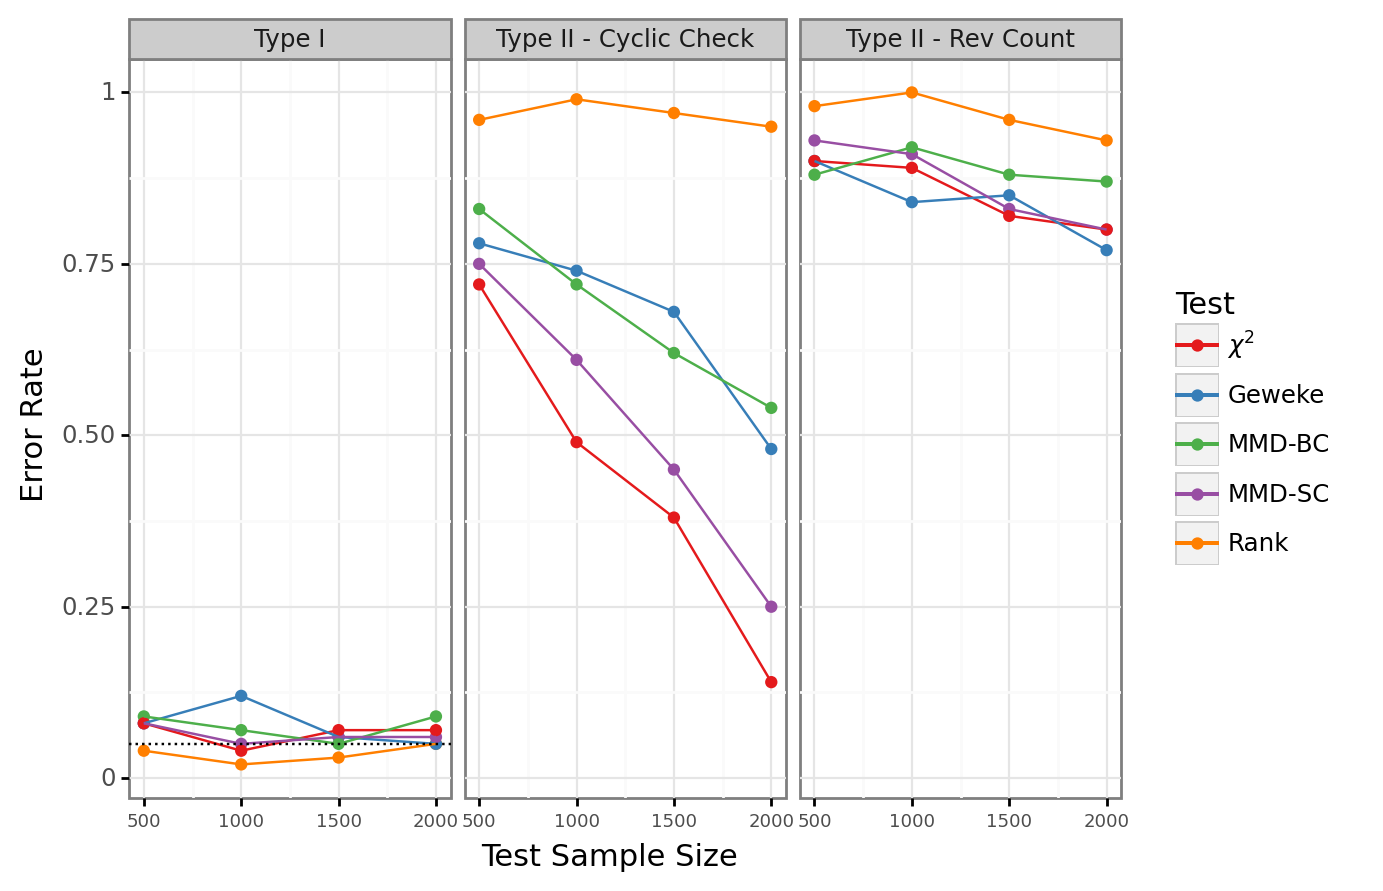

<ggplot: (8763981605825)>

In [46]:
df_results = pd.concat(lst_res)
# df_results=pd.read_pickle('graph_data')
    
df_hline = pd.DataFrame({'experiment':['linear_gaussian_sampler'], 'alpha':[alpha]})
mask = ~df_results.test.str.contains('linear|graph')
plot_results=ggplot(df_results.loc[mask], aes(x='test_size', y='result', color='test', group='test')) + \
    geom_point() + geom_line() + geom_hline(df_hline, aes(yintercept='alpha'), linetype='dotted') +  \
    facet_grid('~experiment', labeller=exp_label) +\
    labs(x='Test Sample Size', y='Error Rate', title='', color='Test') + \
    scale_color_discrete(labels=[r'$\chi^2$', 'Geweke', 'MMD-BC', 'MMD-SC', 'Rank'], palette=palette) + theme_bw() +\
    theme(axis_text_x = element_text(size=6.5))
plot_results

In [47]:
ggsave(plot_results, 'graph_comparison')

/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: graph_comparison


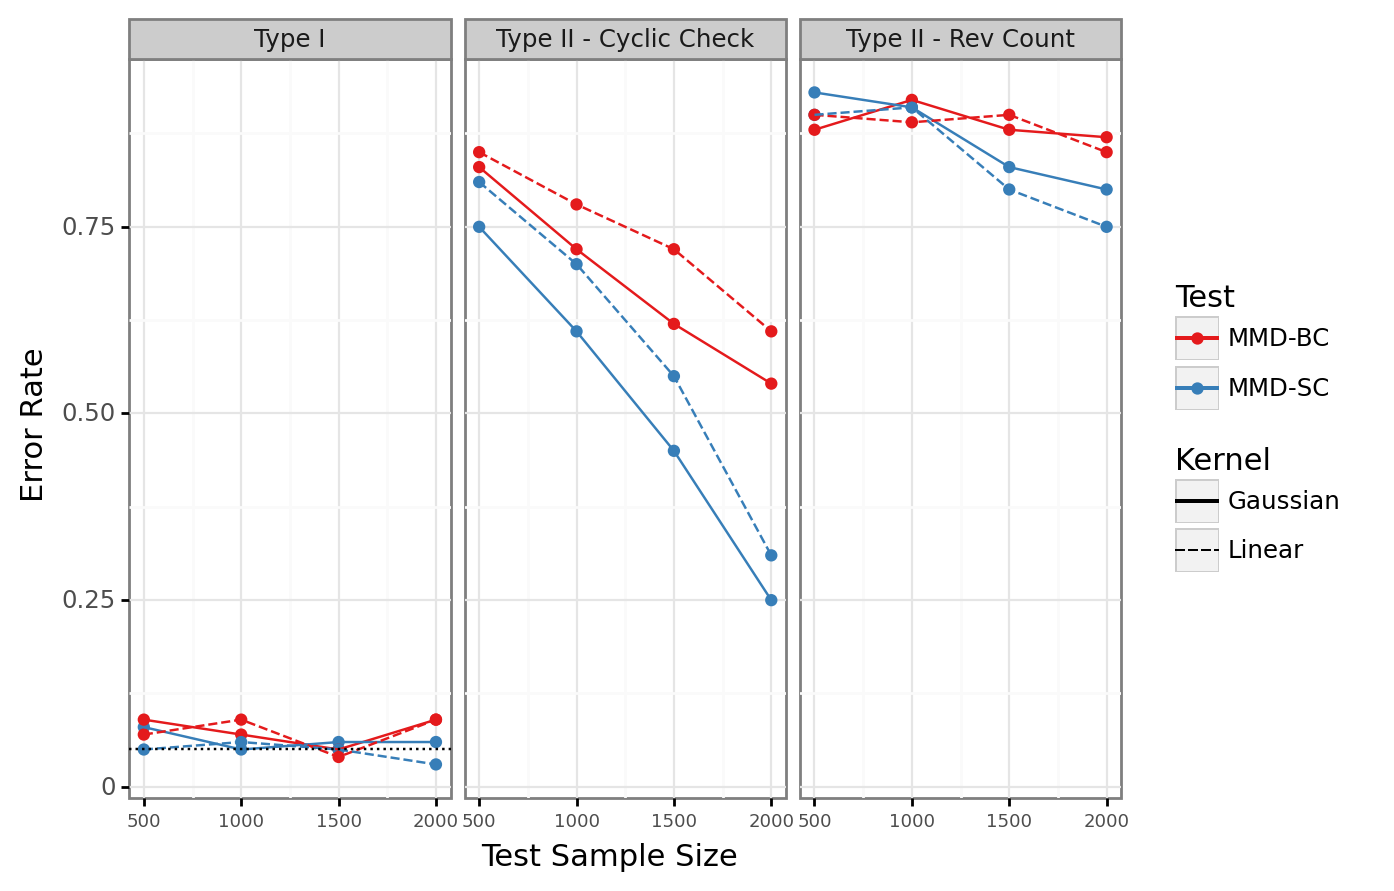

<ggplot: (8764066803014)>

In [50]:
df_plot_kernel = df_results.loc[(df_results.test.str.contains('mmd')) & ~(df_results.test.str.contains('graph'))].reset_index()
df_plot_kernel['kernel'] = df_plot_kernel.apply(lambda x: 'linear' if 'linear' in x.test else 'gaussian', axis=1)
df_plot_kernel['test'] = df_plot_kernel.apply(lambda x: x.test.replace('_linear', ''), axis=1)

plot_results=ggplot(df_plot_kernel, aes(x='test_size', y='result', linetype='kernel', color='test')) + \
    geom_point() + geom_line() + geom_hline(df_hline, aes(yintercept='alpha'), linetype='dotted') +  \
    facet_grid('~experiment', labeller=exp_label) + \
    labs(x='Test Sample Size', y='Error Rate', title='', color='Test', linetype='Kernel') + \
    scale_color_discrete(labels=['MMD-BC', 'MMD-SC'], palette=palette) + \
    scale_linetype_discrete(labels=['Gaussian', 'Linear']) + \
    theme_bw() +\
    theme(axis_text_x = element_text(size=6.5))
plot_results

In [51]:
ggsave(plot_results, 'graph_kernel')

/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: graph_kernel


Using the random walk kernel

In [10]:
def run_trial(model, num_samples, bc_burn_in, sc_thinning, kernel_type, kernel_table, index_table, alpha, seed):
    num_samples = int(num_samples)
    bc_burn_in = int(bc_burn_in)
    sc_thinning = int(sc_thinning)
    
    num_samples_bc = int(1/(bc_burn_in+2) * num_samples)
    num_samples_sc = int((sc_thinning)/(sc_thinning+1) * num_samples)
    
    num_samples_mc_bc = num_samples_bc
    num_samples_mc_sc = num_samples-num_samples_sc
    num_samples_mc = max(num_samples_mc_bc, num_samples_mc_sc)
    
    model.set_seed(seed)
    samples_mc = model.sample_mc(num_samples_mc)
    samples_sc = model.sample_sc(num_samples_sc)[onp.arange(0, num_samples_sc, sc_thinning), :]
    samples_bc = model.sample_bc(num_samples_bc, bc_burn_in)
    
    l_mc = model.test_functions(samples_mc)[:, -1].reshape(-1, 1)
    l_sc = model.test_functions(samples_sc)[:, -1].reshape(-1, 1)
    l_bc = model.test_functions(samples_bc)[:, -1].reshape(-1, 1)
    
    X_mmd_wb = onp.hstack([samples_mc[:, model.theta_indices], l_mc])[:(num_samples-num_samples_sc), :]
    Y_mmd_wb = onp.hstack([samples_sc[:, model.theta_indices], l_sc])
    
    X_mmd = onp.hstack([samples_mc[:, model.theta_indices], l_mc])[:num_samples_bc, :]
    Y_mmd = onp.hstack([samples_bc[:, model.theta_indices], l_bc])

    # Not including likelihood
    rej_mmd_wb = mmd_wb_test(X_mmd_wb[:, :-1], Y_mmd_wb[:, :-1], \
                             graph_kernel, alpha=alpha, \
                             cache_index_table = index_table, cache_kernel_table=kernel_table, kernel_type=kernel_type)['result']
    rej_mmd = mmd_test(X_mmd[:, :-1], Y_mmd[:, :-1], \
                       graph_kernel, alpha=alpha, mmd_type='unbiased', \
                       cache_index_table = index_table, cache_kernel_table=kernel_table, kernel_type=kernel_type)['result']

#     rej_mmd_wb_l = mmd_wb_test(X_mmd_wb, Y_mmd_wb, \
#                        sum_kernel, alpha=alpha, mmd_type='unbiased', \
#                        lst_classes = [graph_kernel, rbf_kernel], lst_groups=[onp.arange(len(model.theta_indices)), onp.array([-1])], \
#                        lst_kwargs=[{'cache_index_table':index_table, 'cache_kernel_table':kernel_table, 'kernel_type':kernel_type}, {}])['result']
    
#     rej_mmd_l = mmd_test(X_mmd, Y_mmd, \
#                        sum_kernel, alpha=alpha, mmd_type='unbiased', \
#                        lst_classes = [graph_kernel, rbf_kernel], lst_groups=[onp.arange(len(model.theta_indices)), onp.array([-1])], \
#                        lst_kwargs=[{'cache_index_table':index_table, 'cache_kernel_table':kernel_table, 'kernel_type':kernel_type}, {}])['result']


#     return onp.array([rej_mmd_wb, rej_mmd_wb_l, rej_mmd, rej_mmd_l])
    return onp.array([rej_mmd_wb, rej_mmd])

In [ ]:
os.environ['MKL_NUM_THREAD'] = '1'

num_nodes = 3
num_trials = 100
alpha = 0.05

bc_burn_in = 5-1
sc_thinning = 5

kernel_type='random_walk'

# Cache
kernel_table, index_table = graph_kernel_cache(num_nodes, kernel_type)

lst_experiments = [linear_gaussian_sampler(num_nodes=num_nodes), linear_gaussian_sampler_error_1(num_nodes=num_nodes), linear_gaussian_sampler_error_2(num_nodes=num_nodes)]
lst_sample_budget = [3000,6000,9000,12000]

lst_res = []

with joblib.Parallel(n_jobs=5) as para:
    for model in tqdm(lst_experiments):
        for n in tqdm(lst_sample_budget):
            num_samples_bc = int(1/(bc_burn_in+2) * n)
            num_samples_sc = int((sc_thinning)/(sc_thinning+1) * n)
            test_size_bc = num_samples_bc
            test_size_sc = n-num_samples_sc

            results = para(joblib.delayed(run_trial)(model, n, bc_burn_in, sc_thinning, kernel_type, kernel_table, index_table, alpha, seed) for seed in range(num_trials))
            results = onp.vstack(results).mean(0)

           # Convert rejection rate to Type I/II error
            if 'error' in type(model).__name__:
                results = 1-results

            lst_test = ['mmd_wb', 'mmd']
            lst_test_size = [test_size_sc, test_size_bc]
            lst_res.append(pd.DataFrame({'experiment': type(model).__name__, 'test':lst_test,  'test_size':lst_test_size, 'sample_budget':n, 'result':results}))

In [15]:
df_graph=pd.concat(lst_res)
df_graph.test = df_graph.test + '_graph'
df_results = pd.read_pickle('graph_data')
df_results=pd.concat([df_results, df_graph])

In [50]:
df_plot_kernel = df_results.loc[df_results.test.str.contains('mmd')].reset_index()
df_plot_kernel.loc[df_plot_kernel.test.str.contains('graph'), 'kernel'] = 'graph'
df_plot_kernel.loc[df_plot_kernel.test.str.contains('linear'), 'kernel'] = 'linear'
df_plot_kernel.loc[df_plot_kernel.kernel.isnull(), 'kernel'] = 'gaussian'
df_plot_kernel['test'] = df_plot_kernel.apply(lambda x: x.test.replace('_linear', ''), axis=1)
df_plot_kernel['test'] = df_plot_kernel.apply(lambda x: x.test.replace('_graph', ''), axis=1)

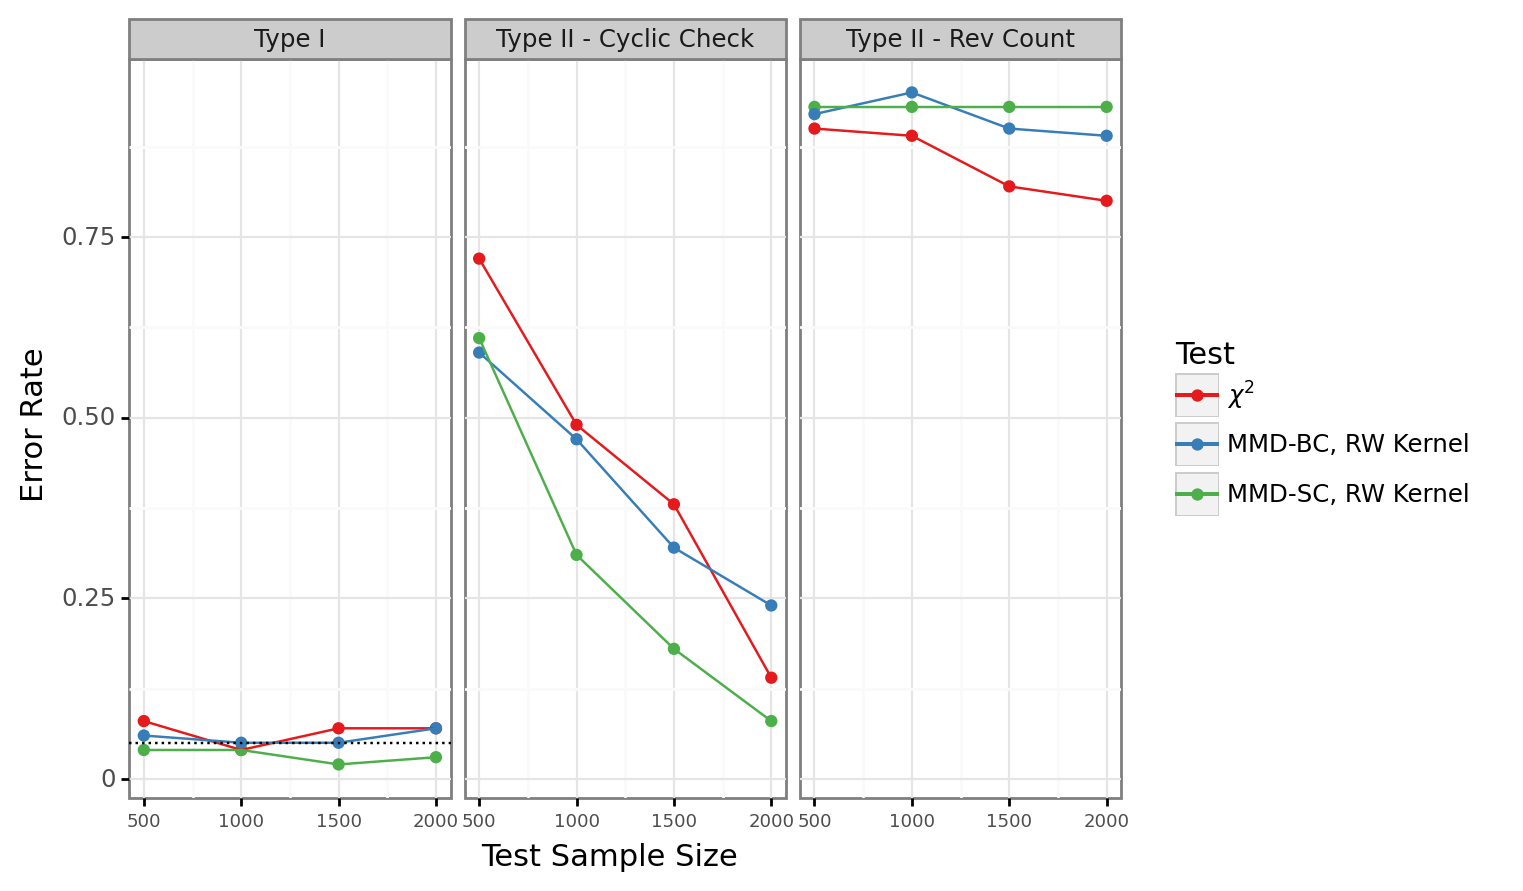

<ggplot: (8764116319407)>

In [52]:
df_hline = pd.DataFrame({'experiment':['linear_gaussian_sampler'], 'alpha':[alpha]})
mask = df_results.test.str.contains('graph|chi')
plot_results=ggplot(df_results.loc[mask], aes(x='test_size', y='result', color='test', group='test')) + \
    geom_point() + geom_line() + geom_hline(df_hline, aes(yintercept='alpha'), linetype='dotted') +  \
    facet_grid('~experiment', labeller=exp_label) +\
    labs(x='Test Sample Size', y='Error Rate', title='', color='Test') + \
    scale_color_discrete(labels=[r'$\chi^2$', 'MMD-BC, RW Kernel', 'MMD-SC, RW Kernel'], palette=palette) + theme_bw() +\
    theme(axis_text_x = element_text(size=6.5))
plot_results

In [54]:
ggsave(plot_results, 'graph_random_walk')

/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: graph_random_walk


Plotting a DAG with igraph

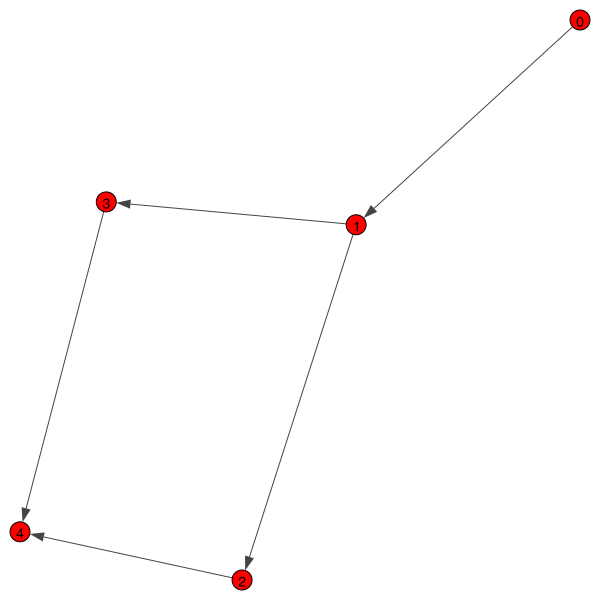

In [15]:
adj_matrix = [[0,1,0,0,0],[0,0,1,1,0],[0,0,0,0,1],[0,0,0,0,1],[0,0,0,0,0]]
g=igraph.Graph.Adjacency(adj_matrix)
g.vs['label'] = list(range(5))
igraph.plot(g)